In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from functools import reduce, partial
from itertools import product
import sound_field_analysis as sfa
from scipy.interpolate import griddata
from spaudiopy.sph import inverse_sht


from toa import smooth_toa
from utils import sht_lstsq_reg, lsd

np.random.seed(114514)

fatal: not a git repository (or any of the parent directories): .git


## Custom functions

In [2]:
def plot_sphere(ax, az, col, v, resolution=100, vmin=None, vmax=None):
    target_az = np.linspace(0, 2 * np.pi, resolution * 2)
    target_col = np.linspace(0, np.pi, resolution)

    az = np.concatenate((az - 2 * np.pi, az, az + 2 * np.pi))
    col = np.concatenate((col, col, col))
    v = np.concatenate((v, v, v))

    lon = np.linspace(-np.pi, np.pi, resolution * 2)
    lat = np.linspace(-np.pi / 2.0, np.pi / 2.0, resolution)

    target_az = lon % (2 * np.pi)
    target_col = -lat + np.pi / 2

    interp = griddata(
        (az, col), v, (target_az[None, :], target_col[:, None]), method="cubic"
    ).reshape((resolution, resolution * 2))
    lon, lat = np.meshgrid(lon, lat)
    return ax.pcolormesh(lon, lat, interp, cmap="RdYlBu", vmin=vmin, vmax=vmax)
    # ax.imshow(interp, cmap=plt.cm.jet, origin="lower", extent=[0, 2 * np.pi, 0, np.pi])


def plot_sphere2(ax, az, col, v, vmin=None, vmax=None, dotsize=10):
    ax.scatter(
        (az + np.pi) % (2 * np.pi) - np.pi,
        -col + np.pi / 2,
        c=v,
        cmap="RdYlBu",
        vmin=vmin,
        vmax=vmax,
        s=dotsize,
    )


def calculate_noise_scaler(signal_power, noise_power, target_snr):
    target_noise_power = signal_power / (10 ** (target_snr / 10))
    return np.sqrt(np.maximum(0, target_noise_power - noise_power))

Prepare HRTF data and loss calculation functions.

In [3]:
sofa_file = "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
hrir_data = sfa.io.read_SOFA_file(sofa_file)

sr = hrir_data.l.fs
az = hrir_data.grid.azimuth
col = hrir_data.grid.colatitude
radius = hrir_data.grid.radius
hrir_xyz = sfa.utils.sph2cart((az, col, radius)).T

hrir = np.stack((hrir_data.l.signal, hrir_data.r.signal), axis=1)
hrtf = np.fft.rfft(hrir, axis=2)
noise = np.random.randn(*hrir.shape)

sph_orders = range(2, 16)

itd_loss = lambda itd, itd_recon: np.mean(np.abs(itd - itd_recon)) * 1e6
hrir_recon = lambda hrir, N: inverse_sht(
    sht_lstsq_reg(hrir.reshape(hrir.shape[0], -1), N, az, col, "real", eps=1e-5),
    az,
    col,
    "real",
).reshape(hrir.shape)


open SOFA file "KEMAR_Knowl_EarSim_SmallEars_FreeFieldComp_44kHz.sofa"
 --> samplerate: 44100 Hz, receivers: 2, emitters: 1, measurements: 828, samples: 256, format: float64
 --> convention: SimpleFreeFieldHRIR, version: 1.0


Calculate measurement noise in the data.

In [4]:
idx = np.argmin(np.abs(hrir_xyz / radius[:, None] - np.array([1, 0, 0])).sum(axis=-1))
ref_hrirs = hrir[idx]

power = ref_hrirs**2
filtered_power = power[power > 0]
# use the top 10% of the power as signal, and the last 10% as noise
sorted_power = np.sort(filtered_power)
n = sorted_power.shape[0]
signal_power = np.mean(sorted_power[-int(n * 0.1) :])
noise_power = np.mean(sorted_power[: int(n * 0.1)])
inherent_snr = 10 * np.log10(signal_power / noise_power)
print(f"Measured SNR: {inherent_snr} dB")

Measured SNR: 75.09271116801014 dB


Simulate noisy data with different noise levels.

In [5]:
target_snrs = [36, 18, 10]
noise_scalers = map(
    partial(calculate_noise_scaler, signal_power, noise_power), target_snrs
)

noisy_hrirs = [hrir + s * noise for s in noise_scalers]
noisy_hrtfs = [np.fft.rfft(nh, axis=2) for nh in noisy_hrirs]

Pre-calculate TOA and ITD for HRTF data.

In [6]:
toas = {
    f"{method}_{snr}_{without_toa}_{without_cross}": smooth_toa(
        noisy_hrirs[target_snrs.index(snr)],
        hrir_xyz,
        sr,
        method,
        oversampling=10,
        ignore_toa=without_toa,
        ignore_cross=without_cross,
        weighted=True,
        toa_weight=0.1,
        verbose=False,
    )[0]
    for snr, method, without_toa, without_cross in product(
        target_snrs, ["edgelist", "l2"], [True, False], [True, False]
    )
}
itds = {k: (toa[:, 0] - toa[:, 1]) / sr for k, toa in toas.items()}

Compute LSD score for ITD and aligned-HRIRs.

In [7]:
itd_losses = {
    k: [itd_loss(itd, hrir_recon(itd, N)) for N in sph_orders]
    for k, itd in itds.items()
}

In [8]:
def get_lsd_scores(hrtf, noisy_hrtf, toa, orders):
    shifts = toa - toa.min(0)
    shifter = np.exp(
        2j * np.pi * np.arange(hrtf.shape[-1]) / hrir.shape[-1] * shifts[..., None]
    )
    aligned_hrir = np.fft.irfft(noisy_hrtf * shifter, axis=2)

    lsd_raw = [
        lsd(hrtf, np.fft.rfft(hrir_recon(aligned_hrir, n), axis=2) * shifter.conj())
        for n in orders
    ]
    lsd_freqs = [lsd.mean((0, 1)) for lsd in lsd_raw]
    lsd_losses = [lsd.mean() for lsd in lsd_freqs]
    return lsd_losses, lsd_freqs


lsd_losses = reduce(
    lambda a, b: a | b,
    (
        dict(
            zip(
                [k, k + "_freq"],
                get_lsd_scores(
                    hrtf,
                    noisy_hrtfs[target_snrs.index(int(k.split("_")[1]))],
                    toa,
                    sph_orders,
                ),
            )
        )
        for k, toa in toas.items()
    ),
)

Plot the result. This reproduce Figure 2 in the AES paper.

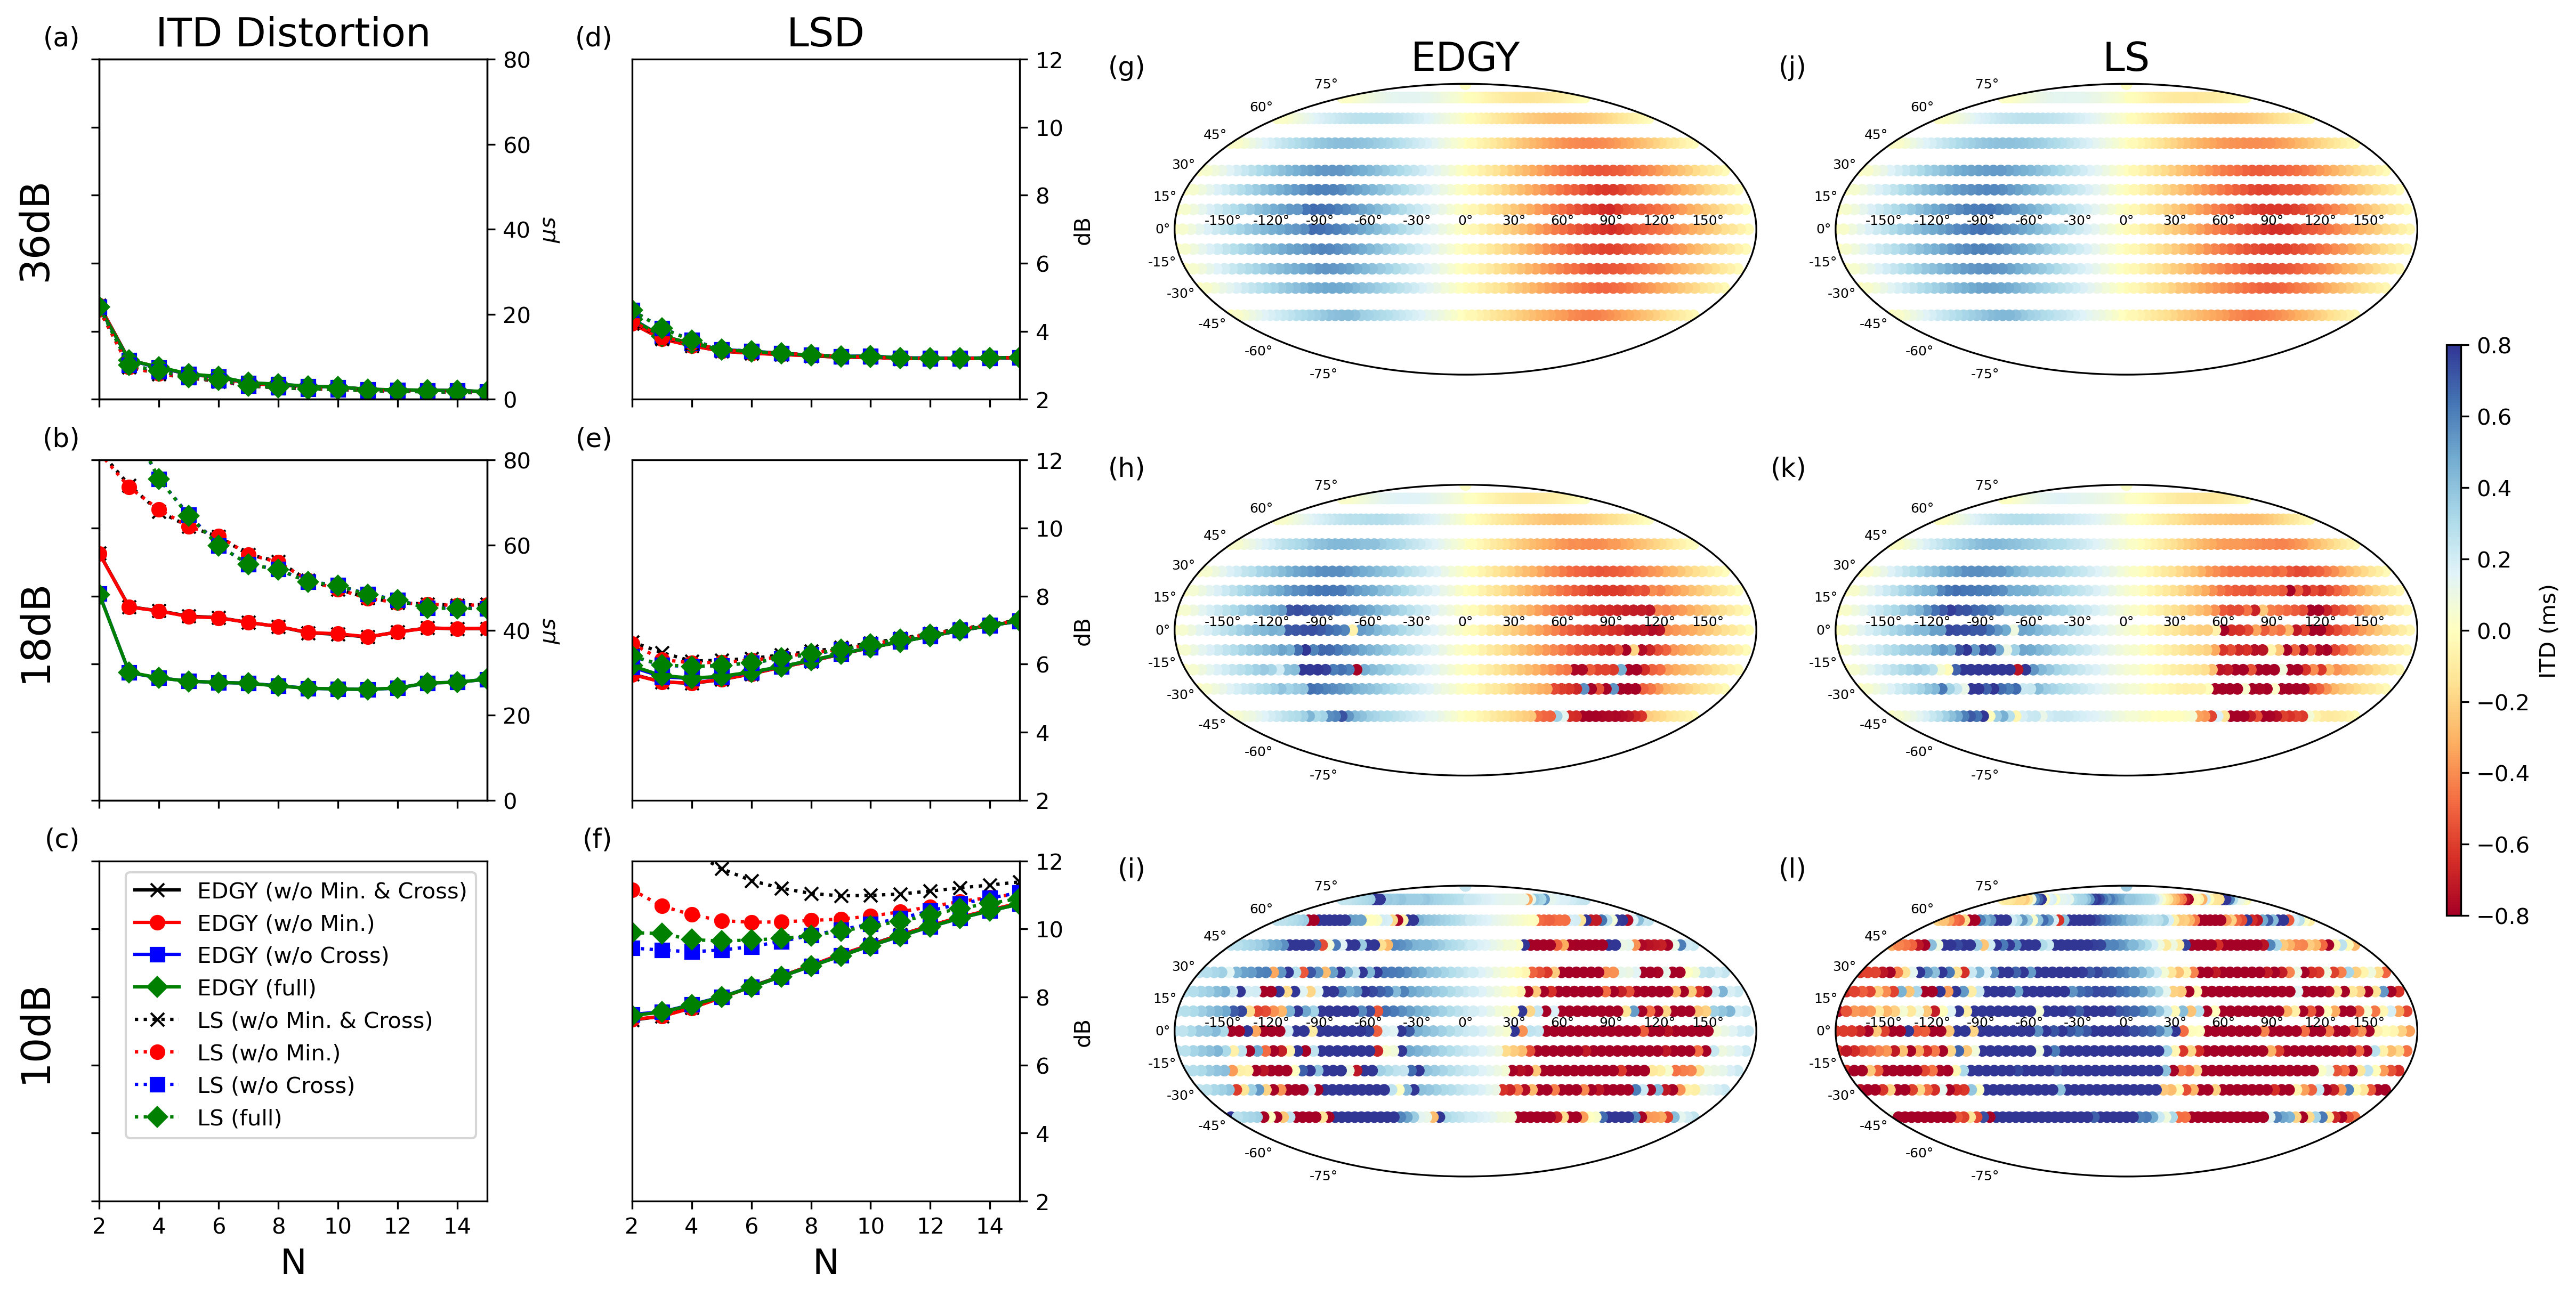

In [9]:
# fig, ax = plt.subplots(2, len(target_snrs), figsize=(10, 6), sharey="row", sharex="all", dpi=300)
fig = plt.figure(figsize=(16, 8), dpi=300, layout="constrained")
gs = fig.add_gridspec(len(target_snrs), 4, width_ratios=[1, 1, 1.5, 1.5])

axes = []
for r, snr in enumerate(target_snrs):
    ax1 = fig.add_subplot(gs[r, 0], sharex=axes[r - 1][0] if r > 0 else None)
    ax1.annotate(
        f"{snr}dB",
        xy=(0, 0.5),
        xytext=(-ax1.yaxis.labelpad - 5, 0),
        xycoords=ax1.yaxis.label,
        textcoords="offset points",
        size=18,
        ha="right",
        va="center",
        rotation=90,
    )
    if r < len(target_snrs) - 1:
        ax1.tick_params(labelbottom=False)
    ax1.set_yticklabels([])
    backup_ax1 = ax1
    ax1 = ax1.twinx()
    ax1.set_ylabel("$\mu s$")
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    ax2 = fig.add_subplot(gs[r, 1], sharex=axes[r - 1][1] if r > 0 else None)
    ax2.set_ylabel("dB")
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    if r < len(target_snrs) - 1:
        ax2.tick_params(labelbottom=False)

    ax3 = fig.add_subplot(gs[r, 2], projection="mollweide")
    ax4 = fig.add_subplot(gs[r, 3], projection="mollweide")

    ax3.tick_params(labelsize=6)
    ax4.tick_params(labelsize=6)

    if r == 0:
        ax1.set_title("ITD Distortion", fontsize=18)
        ax2.set_title("LSD", fontsize=18)
        ax3.set_title("EDGY", fontsize=18)
        ax4.set_title("LS", fontsize=18)
    elif r == len(target_snrs) - 1:
        backup_ax1.set_xlabel("N", fontsize=16)
        ax2.set_xlabel("N", fontsize=16)

        ax1.set_xticks(sph_orders[::2])
        ax2.set_xticks(sph_orders[::2])

    axes.append([ax1, ax2, ax3, ax4])

for r, c in product(range(len(target_snrs)), range(4)):
    subplot_label = "(" + chr(ord("a") + r + c * len(target_snrs)) + ")"
    axes[r][c].text(
        -0.05,
        1.1,
        subplot_label,
        transform=axes[r][c].transAxes,
        fontsize=12,
        va="top",
        ha="right",
    )


for r, c in product(range(len(target_snrs)), range(2)):
    snr = target_snrs[r]
    data = itd_losses if c == 0 else lsd_losses
    for k, v in filter(
        lambda x: (snr == int(x[0].split("_")[1])) and not ("_freq" in x[0]),
        data.items(),
    ):
        method, _, without_toa, without_cross = k.split("_")
        label = f"{'EDGY' if method == 'edgelist' else 'LS'}"
        if without_toa == "True" and without_cross == "True":
            label += " (w/o Min. & Cross)"
            color = "black"
            marker = "x"
        elif without_toa == "True":
            label += " (w/o Min.)"
            color = "red"
            marker = "o"
        elif without_cross == "True":
            label += " (w/o Cross)"
            color = "blue"
            marker = "s"
        else:
            label += " (full)"
            color = "green"
            marker = "D"
        axes[r][c].plot(
            sph_orders,
            v,
            label=label,
            linestyle="dotted" if method == "l2" else "-",
            marker=marker,
            color=color,
            markersize=6,
        )

vmax = 0.8
vmin = -0.8
plot_sphere_simple = partial(
    plot_sphere2, az=az, col=col, vmin=vmin, vmax=vmax, dotsize=18
)

for r, c in product(range(len(target_snrs)), range(2)):
    v = itds[f"{['edgelist', 'l2'][c]}_{target_snrs[r]}_True_True"]
    im = plot_sphere_simple(axes[r][c + 2], v=v * 1e3)

cbar = fig.colorbar(
    cm.ScalarMappable(cmap="RdYlBu", norm=cm.colors.Normalize(vmin=vmin, vmax=vmax)),
    ax=[x[-1] for x in axes],
    orientation="vertical",
    # fraction=0.03,
    # pad=0.03,
    aspect=40,
    shrink=0.5,
    location="right",
    label="ITD (ms)",
)


for r in range(len(target_snrs)):
    axes[r][0].set_ylim([0, 80])
    axes[r][1].set_ylim([2, 12])
    axes[r][0].set_xlim([2, 15])
    axes[r][1].set_xlim([2, 15])

axes[-1][0].legend()
axes[-1][0].set_axis_off()

# plt.tight_layout()
plt.show()